### Dataframe de ejemplo para el treemap

In [4]:
import pandas as pd

victimas_por_entidad = pd.DataFrame({
    'ENTIDAD FEDERATIVA': [
        'Jalisco', 'Guanajuato', 'Michoacán', 'Sonora', 'Oaxaca',
        'Estado de México', 'Durango', 'Nuevo León', 'Coahuila', 'Tamaulipas',
        'Puebla', 'Ciudad de México', 'Guerrero', 'Veracruz', 'Chiapas'
    ],
    'NUMERO DE VICTIMAS': [
        910, 750, 664, 516, 508,
        485, 380, 320, 264, 171,
        156, 152, 137, 121, 70
    ]
})



In [11]:
import subprocess

def limpiar_svg_con_svgo(input_file, output_file, config_file=None):
    command = ["svgo", input_file, "-o", output_file]
    if config_file:
        command.extend(["--config", config_file])
    subprocess.run(command, check=True)

def limpiar_svg_con_scour(input_file, output_file):
    subprocess.run([
        "scour",
        "--enable-id-stripping",
        "--enable-comment-stripping",
        "--shorten-ids",
        "--indent=none",
        "--strip-xml-prolog",
        "--remove-metadata",
        "--no-line-breaks",
        "-i", input_file,
        "-o", output_file
    ], check=True)


### **Código a copiar para el treemap:**


treemap_victimas_por_entidad.svg:
Done in 68 ms!
14.779 KiB - 34.6% = 9.666 KiB
Scour processed file "treemap_victimas_por_entidad_svgo.svg" in 13 ms: 7101/9898 bytes new/orig -> 71.7%
SVG optimizado listo: treemap_victimas_por_entidad_final.svg


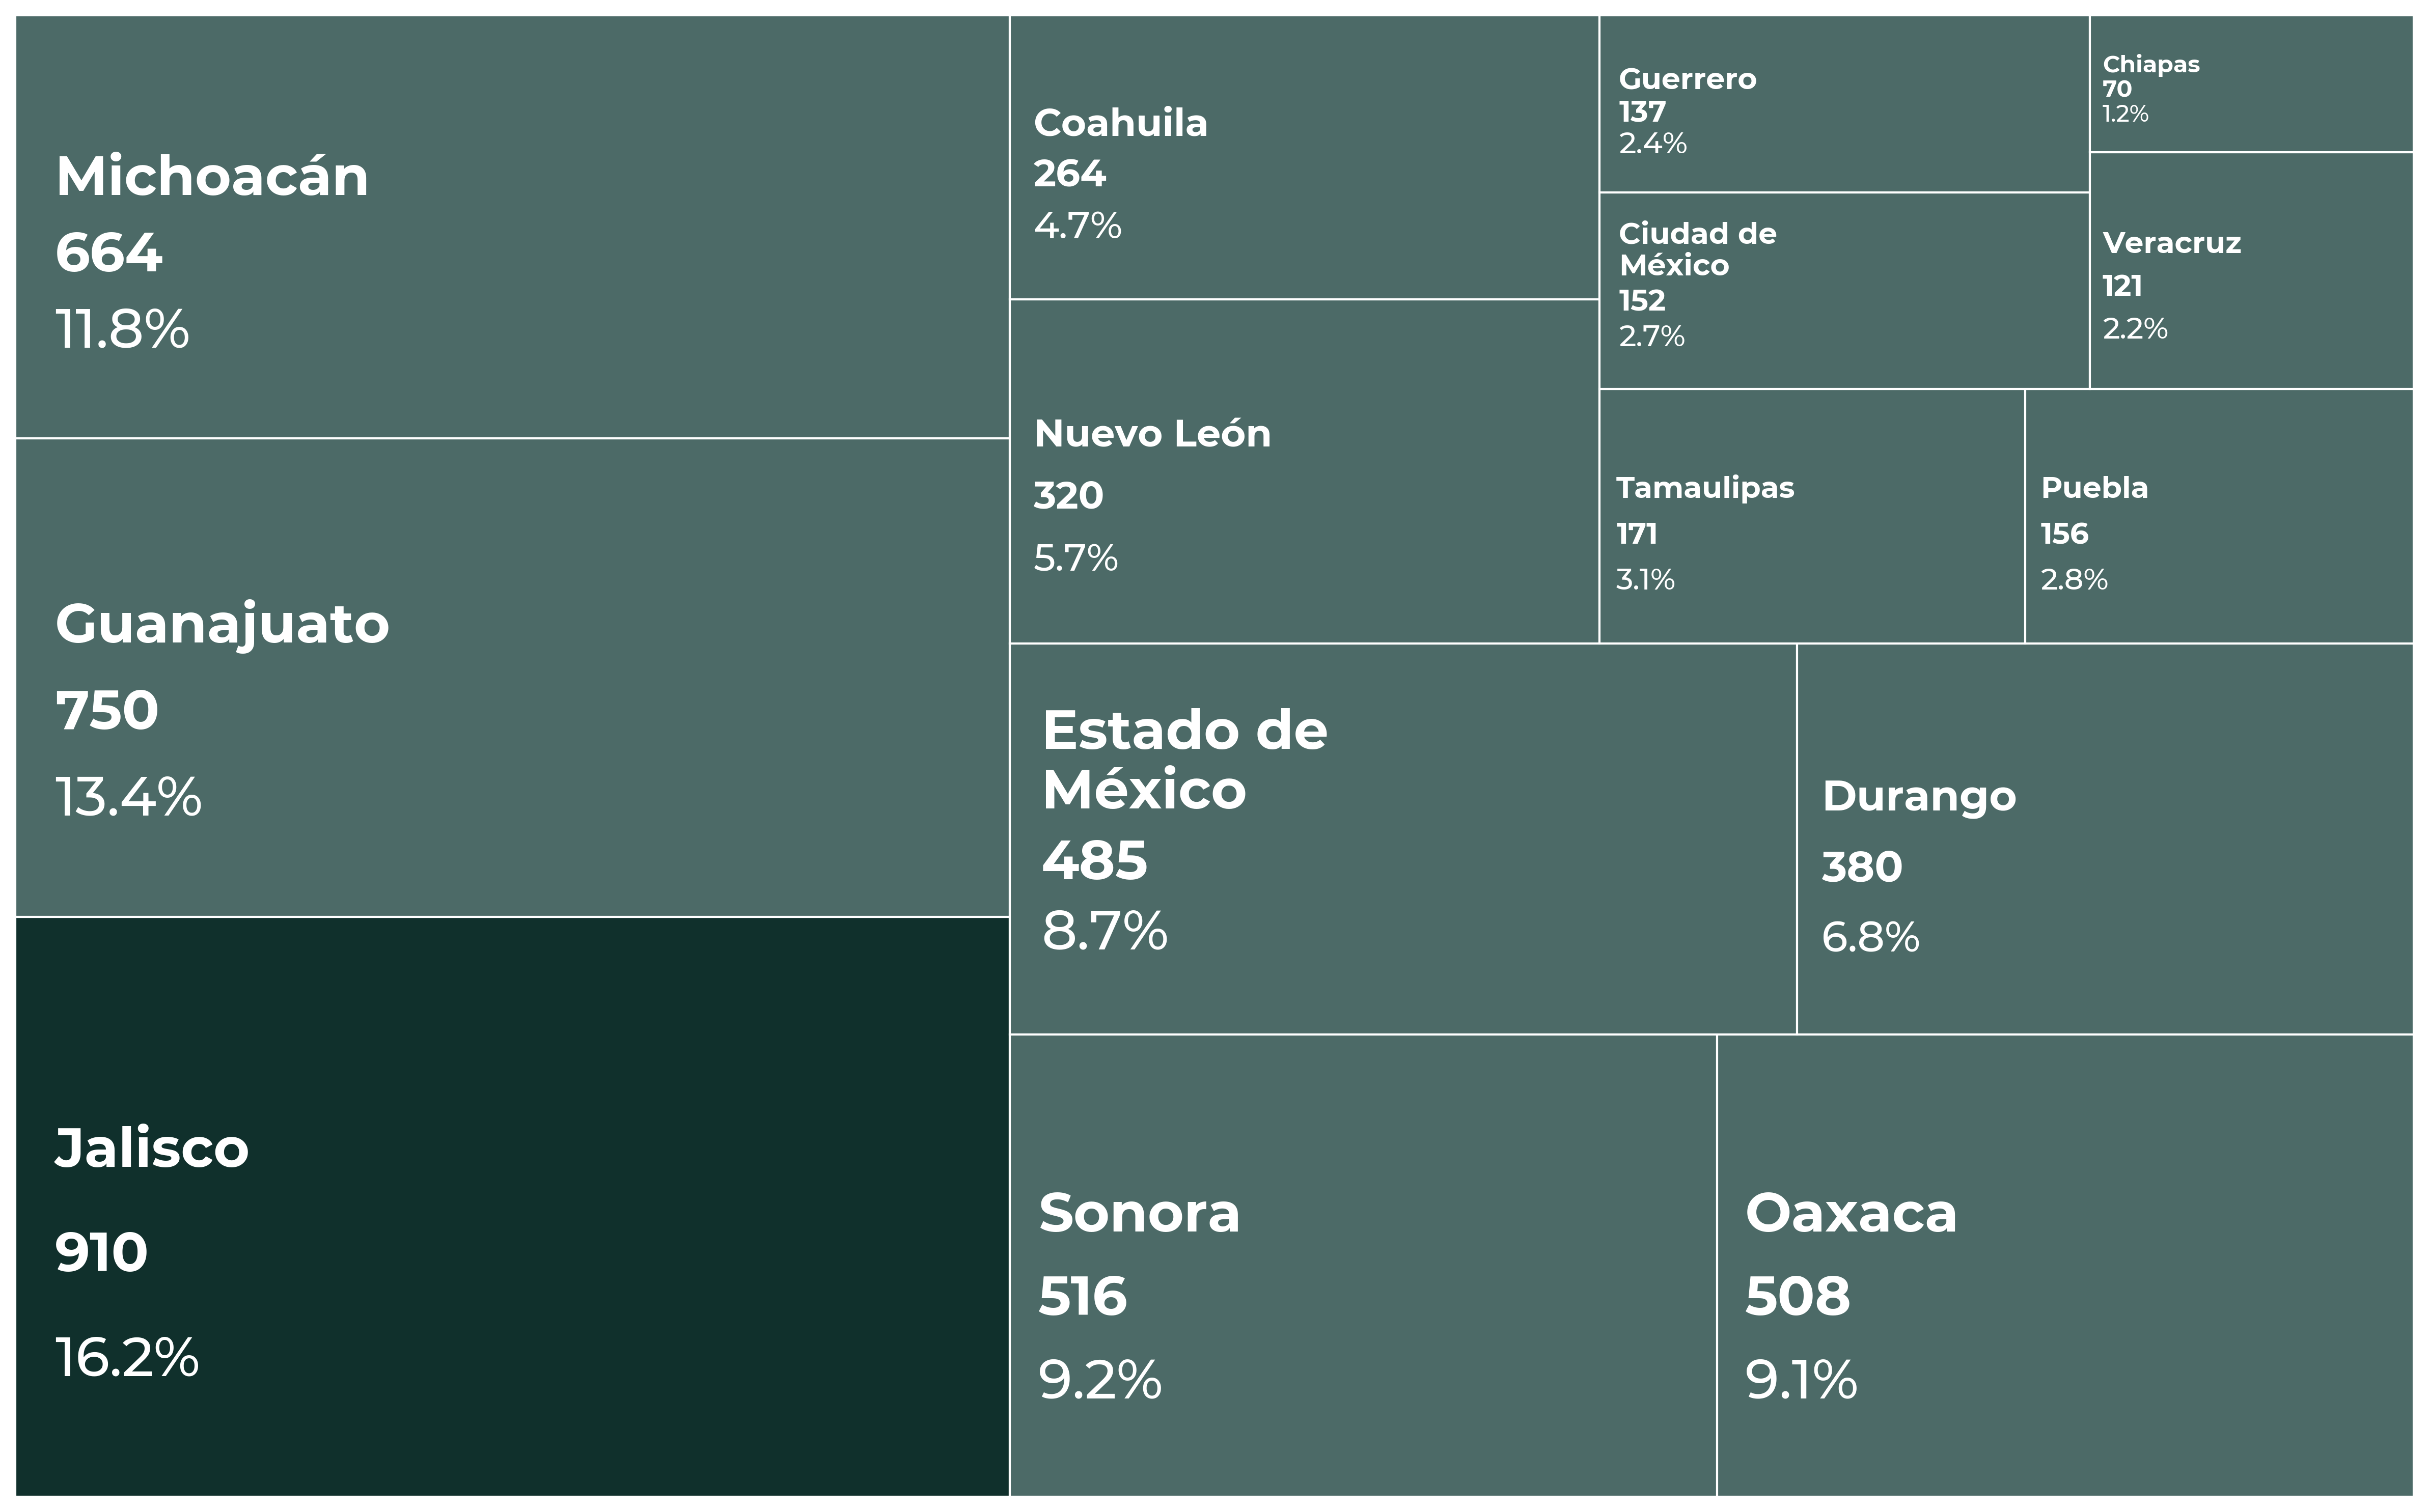

In [14]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import squarify 
import pandas as pd

def treemap(victimas_por_entidad, 
            nombre=None, 
            area_min=0.001, 
            font='Montserrat',
            fontsize_etiqueta=26, 
            fontsize_valor=26, 
            fontsize_porcentaje=26
            ):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import font_manager
    import squarify
    from pathlib import Path

    # Configuración de fuentes y colores
    font_config = {
        'family': font,
        'etiquetas': {'size': fontsize_etiqueta, 'weight': 'bold', 'color': '#ffffff'},
        'valor': {'size': fontsize_valor, 'weight': 'bold', 'color': '#ffffff'},
        'porcentaje': {'size': fontsize_porcentaje, 'weight': 'medium', 'color': '#ffffff'}
    }

    plt.rcParams['svg.fonttype'] = 'none'
    font_dirs = [Path("../0_fonts")]
    font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)

    # Asegurar que todos los valores sean numéricos tipo float
    victimas_por_entidad['NUMERO DE VICTIMAS'] = pd.to_numeric(
        victimas_por_entidad['NUMERO DE VICTIMAS'], errors='coerce'
    ).fillna(0).astype(float)

    # Ordenar y calcular porcentaje
    df = victimas_por_entidad.sort_values(by='NUMERO DE VICTIMAS', ascending=False).copy()
    total_nacional = df['NUMERO DE VICTIMAS'].sum()
    df['Porcentaje'] = (df['NUMERO DE VICTIMAS'] / total_nacional * 100).round(1)

    # Colores
    max_valor = df['NUMERO DE VICTIMAS'].max()
    colores = ['#10302C' if val == max_valor else '#4C6A67' for val in df['NUMERO DE VICTIMAS']]

    # Configurar la figura
    plt.rc('font', family=font_config['family'])
    fig, ax = plt.subplots(figsize=(16, 10), dpi=300)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # rectangulos
    sizes = df['NUMERO DE VICTIMAS'].tolist()
    rectangles = squarify.normalize_sizes(sizes, 1, 1)
    rectangles = squarify.squarify(rectangles, 0, 0, 1, 1)

    # Proporciones originales
    proporciones = {
        0.08: 26,
        0.06: 20,
        0.04: 18,
        0.02: 14,
        0.01: 11,
        0.005: 9,
        0: 5
    }

    def calcular_fontsize(area, base):
        if area > 0.08:
            return base
        elif area > 0.06:
            return int(base * 20 / 26)
        elif area > 0.04:
            return int(base * 18 / 26)
        elif area > 0.02:
            return int(base * 14 / 26)
        elif area > 0.01:
            return int(base * 11 / 26)
        elif area > 0.005:
            return int(base * 9 / 26)
        else:
            return int(base * 5 / 26)

    for rect, (_, row), color in zip(rectangles, df.iterrows(), colores):
        x, y, dx, dy = rect['x'], rect['y'], rect['dx'], rect['dy']

        ax.add_patch(plt.Rectangle(
            (x, y), dx, dy,
            facecolor=color,
            edgecolor='white',
            linewidth=1
        ))

        area = dx * dy

        if area > area_min:
            entidad = row['ENTIDAD FEDERATIVA']
            palabras = entidad.split()
            if len(palabras) > 2:
                entidad_mod = '\n'.join([' '.join(palabras[i:i+2]) for i in range(0, len(palabras), 2)])
            else:
                entidad_mod = entidad

            # Ajuste de tamaño de fuente según argumentos o área
            fontsize_et = calcular_fontsize(area, fontsize_etiqueta)
            fontsize_val = calcular_fontsize(area, fontsize_valor)
            fontsize_pct = calcular_fontsize(area, fontsize_porcentaje)

            x_text = x + dx * 0.04
            y_text = y + dy * 0.55
            y_text2 = y_text - dy * 0.18
            y_text3 = y_text2 - dy * 0.18

            ax.text(
                x_text,
                y_text,
                entidad_mod,
                ha='left',
                va='bottom',
                fontsize=fontsize_et,
                fontweight=font_config['etiquetas']['weight'],
                color=font_config['etiquetas']['color'],
                zorder=10
            )
            ax.text(
                x_text,
                y_text2,
                f"{int(row['NUMERO DE VICTIMAS']):,}",
                ha='left',
                va='bottom',
                fontsize=fontsize_val,
                fontweight=font_config['valor']['weight'],
                color=font_config['valor']['color'],
                zorder=10
            )
            ax.text(
                x_text,
                y_text3,
                f"{row['Porcentaje']}%",
                ha='left',
                va='bottom',
                fontsize=fontsize_pct,
                fontweight=font_config['porcentaje']['weight'],
                color=font_config['porcentaje']['color'],
                zorder=10
            )

        ax.axis('off')
    plt.tight_layout()

    nombre_df = nombre or "treemap"
    archivo_svg = f"{nombre_df}.svg"
    archivo_svg_svgo = f"{nombre_df}_svgo.svg"
    archivo_svg_final = f"{nombre_df}_final.svg"

    # Guardar figura base
    plt.savefig(archivo_svg, format='svg', bbox_inches='tight')
    plt.savefig(f"{nombre_df}.png", format='png', bbox_inches='tight')

    # Optimización en 2 pasos
    limpiar_svg_con_svgo(archivo_svg, archivo_svg_svgo)
    limpiar_svg_con_scour(archivo_svg_svgo, archivo_svg_final)

    print(f"SVG optimizado listo: {archivo_svg_final}")
    plt.show()

treemap(victimas_por_entidad, nombre="treemap_victimas_por_entidad")